# **SVBO transactions segmentation**

In [111]:

## Installs - run once for new session of this Notebook
!pip install mistralai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00


In [112]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
# import class
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Imports
from mistralai import Mistral
from google.colab import userdata

# get API-KEY from Colab
api_key = userdata.get('mistral')
model = "mistral-large-latest"
client = Mistral(api_key=api_key)


# ===== function to calculate optimal number of clusters
def find_optimal_clusters(wcss_values):
     # Calculate the first derivative (rate of change) of the WCSS values
    derivatives = [wcss_values[i] - wcss_values[i + 1] for i in range(len(wcss_values) - 1)]

     # Calculate the second derivative (rate of change of the first derivative)
    second_derivatives = [derivatives[i] - derivatives[i + 1] for i in range(len(derivatives) - 1)]

     # Find the first index where the second derivative is zero or less, which indicates the elbow point
    for  i in range(len(second_derivatives)):
      # init variable
      elbow_index = 0;
      # if found set index and break
      if second_derivatives[i] <= 0:
        elbow_index = i
        break
      # If not  found, use the last index as a fallback
      elbow_index = len(second_derivatives) - 1

     # The optimal number of clusters is the index
    optimal_clusters = elbow_index
    return optimal_clusters
# =======

In [113]:
botrans_df = pd.read_csv('/content/output.csv', sep = ';')
botrans_df.head()


,oper_date,issuer_card_id,mcc,merchant_city,merchant_country,oper_amount_amount_value,oper_amount_currency,oper_type
0,2013-06-21 18:12:36,100000000189,5192,moscow,643,20000.0,643,OPTP0011
1,2013-06-21 18:12:36,100000000026,5192,moscow,643,20000.0,643,OPTP0026
2,2014-03-19 17:08:15,100000000348,6532,LOCAL,643,1000.0,643,OPTP0026
3,2014-03-19 17:27:08,100000000348,6532,LOCAL,643,1000.0,643,OPTP0026
4,2014-03-19 17:27:23,100000000348,6532,LOCAL,643,1000.0,643,OPTP0026


In [83]:
# botrans_df.info()

In [84]:
# botrans_df.describe()

In [85]:
 # botrans_df.shape

In [86]:
# botrans_df.isnull().sum()

In [114]:
# dropping columns - leave dome for clusterization
#cut_botrans = botrans_df.drop(['oper_date','issuer_card_id','mcc','merchant_country','oper_amount_currency'], axis=1, inplace=True)
#cut_botrans = botrans_df.drop(['oper_date','issuer_card_id','mcc','merchant_city','merchant_country','oper_amount_currency'], axis=1, inplace=False)

#cut_botrans = botrans_df.drop(['issuer_card_id','merchant_country','merchant_city','oper_amount_currency','oper_type'], axis=1, inplace=False)
#cut_botrans = botrans_df.drop(['issuer_card_id','merchant_country','merchant_city','mcc','oper_amount_currency','oper_type'], axis=1, inplace=False)
#cut_botrans = botrans_df.drop(['oper_date','issuer_card_id','merchant_city','oper_amount_currency'], axis=1, inplace=False)

# with amount
cut_botrans = botrans_df.drop(['oper_date','issuer_card_id','merchant_city'], axis=1, inplace=False)


# scaling
# cut_botrans['mcc'] = cut_botrans['mcc'] / 100
# cut_botrans[id]=cut_botrans.index
# cut first 4 letters OPTPT from 'oper_type' values
cut_botrans['oper_type'] = cut_botrans['oper_type'].str[4:]
cut_botrans['oper_type'] = cut_botrans['oper_type'].astype(int)
# cut_botrans['merchant_country'] = cut_botrans['merchant_country']/10

# create scaler object
scaler = StandardScaler()
#scale set
cut_botrans_scaled = scaler.fit_transform(cut_botrans)
# create dataframe from scaled array
cut_botrans_scaled_df = pd.DataFrame(cut_botrans_scaled)
#restore column names from orig DF
cut_botrans_scaled_df.columns = cut_botrans.columns
# check what we have got
cut_botrans_scaled_df.head()

,mcc,merchant_country,oper_amount_amount_value,oper_amount_currency,oper_type
0,-1.167684,-0.023647,-0.058328,-0.177713,0.181829
1,-1.167684,-0.023647,-0.058328,-0.177713,1.254785
2,1.441409,-0.023647,-0.059483,-0.177713,1.254785
3,1.441409,-0.023647,-0.059483,-0.177713,1.254785
4,1.441409,-0.023647,-0.059483,-0.177713,1.254785


(9910, 5)


Text(0, 0.5, 'oper_amount_amount_value')

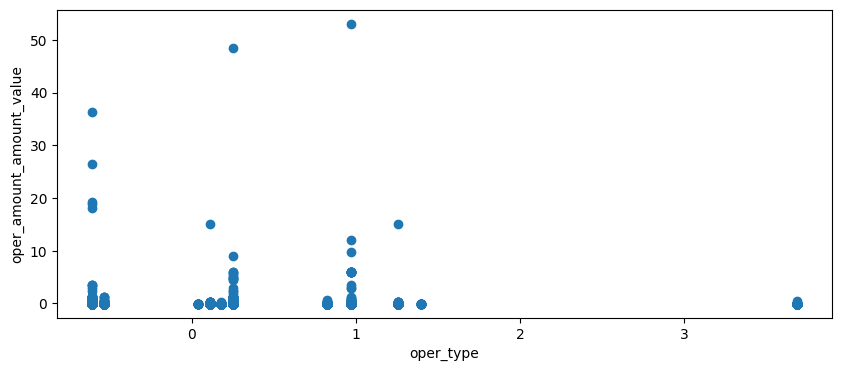

In [115]:
# set source variable
X = cut_botrans_scaled_df
print(X.shape)

# plot our DF to check
plt.figure(figsize = (10,4))
plt.scatter(X.iloc[:,4], X.iloc[:,2])
# take labels from DataFrame
plt.xlabel(X.columns.values[4])
plt.ylabel(X.columns.values[2])

[49549.99999999877, 41543.10807201248, 34662.59346263167, 27735.620556497848, 20299.90848214594, 16079.16967908985, 13224.595398059324, 11388.60036368786, 9320.146723071513, 8089.283853456063]
The optimal number of clusters is: 1


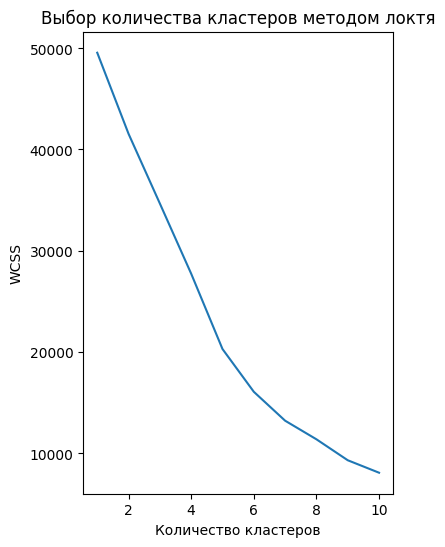

In [116]:
# define number of clusters
# set empty list for WCSS (error)
wcss = []
# range from 1 to 10 (index starts with 0)
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
  # fit model with different clusters number
  kmeans.fit(X)
  # calculate error for each ckuster (inertia_) and putt it list
  wcss.append(kmeans.inertia_)

# plot WCSS
plt.figure(figsize = (4,6))
plt.plot(range(1, 11), wcss)
# add titles
plt.title('Выбор количества кластеров методом локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')

# print WCSS for check
print(wcss)
# call function to analyze WCSS graph and define optimum number of clusters
optimal_clusters = find_optimal_clusters(wcss)
print(f"The optimal number of clusters is: {optimal_clusters}")

optimal_clusters = 6

In [117]:
# run fit with defined optimal number of clusters
kmeans = KMeans(n_clusters = optimal_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_pred = kmeans.fit_predict(X)
#y_pred.labels_

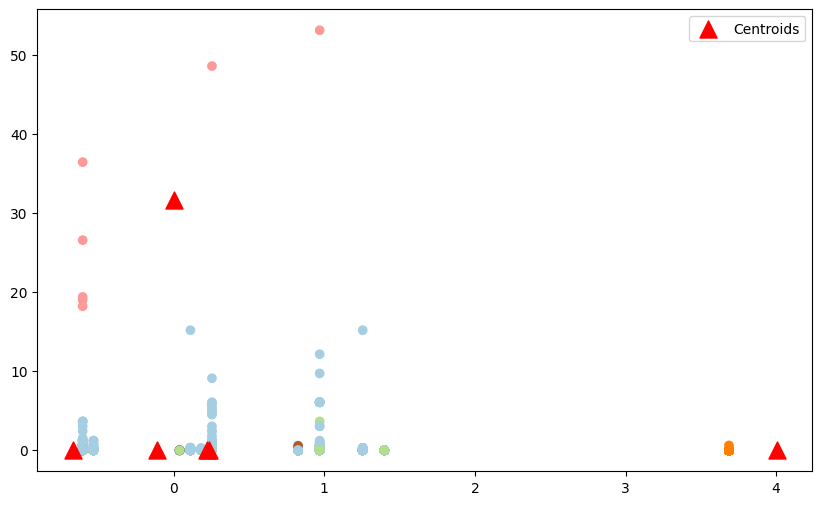

In [118]:
# plot graph with centroids
plt.figure(figsize = (10,6))
# c - specifies color of dots according to cluster number
plt.scatter(X.iloc[:,4], X.iloc[:,2], c = y_pred, cmap='Paired')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,2], s = 150, c = 'red', marker = '^', label = 'Centroids')
# put legend
plt.legend(loc = 'upper right')


In [119]:
# add new column to dataframe with calculated cluster number
cut_botrans["Cluster"] = kmeans.labels_
cut_botrans.head()

,mcc,merchant_country,oper_amount_amount_value,oper_amount_currency,oper_type,Cluster
0,5192,643,20000.0,643,11,0
1,5192,643,20000.0,643,26,0
2,6532,643,1000.0,643,26,0
3,6532,643,1000.0,643,26,0
4,6532,643,1000.0,643,26,0


In [120]:
cut_botrans["Cluster"].value_counts()

,count
Cluster,
0,8321
1,751
3,461
5,255
4,115
2,7


In [94]:
# example how to return cut columns to DF here it is issuer_card_id
# cut_botrans["issuer_card_id"] = botrans_df["issuer_card_id"]

# get row where value of Cluster column = 1
# print(cut_botrans[ cut_botrans["Cluster"] == 1])
# card_id = 100000005157 need to remove it


In [121]:
# set variable for all printouts
output = ""
# start loop by cluster number
for label in range (optimal_clusters):

# sample: output += f"  Maximum Amount: {max_amount}\n"
  output += f"Cluster number: {label}\n"
# create df with particular cluster value
  df_cluster = cut_botrans[cut_botrans.Cluster == label]

# Basic descriptive statistics
  max_amount = df_cluster["oper_amount_amount_value"].max()
  min_amount = df_cluster["oper_amount_amount_value"].min()
  avg_amount = df_cluster["oper_amount_amount_value"].mean()
  std_amount = df_cluster["oper_amount_amount_value"].std()
  total_amount = df_cluster["oper_amount_amount_value"].sum()
  num_transactions = df_cluster.shape[0]

  output += f"  Maximum Amount: {max_amount}\n"
  output += f"  Minimum Amount: {min_amount}\n"
  output += f"  Average Amount: {avg_amount}\n"
  output += f"  Standard Deviation of Amount: {std_amount}\n"
  output += f"  Total Amount: {total_amount}\n"
  output += f"  Number of Transactions: {num_transactions}\n"

# Most frequent categories
  most_frequent_mcc = df_cluster["mcc"].mode()[0]
  most_frequent_country = df_cluster["merchant_country"].mode()[0]
  most_frequent_currency = df_cluster["oper_amount_currency"].mode()[0]

  output += f"  Most Frequent MCC: {most_frequent_mcc}\n"
  output += f"  Most Frequent Merchant Country: {most_frequent_country}\n"
  output += f"  Most Frequent Operation Currency: {most_frequent_currency}\n"

# Distribution of categories
  mcc_distribution = df_cluster["mcc"].value_counts()
  country_distribution = df_cluster["merchant_country"].value_counts()
  currency_distribution = df_cluster["oper_amount_currency"].value_counts()

  output += "  MCC Distribution:\n"
  # note here MCC printed as first 10 records
  output += f"{mcc_distribution.head()}\n"
  output += "  Merchant Country Distribution:\n"
  output += f"{country_distribution}\n"
  output += "  Operation Currency Distribution:\n"
  output += f"{currency_distribution}\n\n"

print(output)


Cluster number: 0
  Maximum Amount: 250000000.0
  Minimum Amount: 2.0
  Average Amount: 706631.5235428434
  Standard Deviation of Amount: 7251072.372857212
  Total Amount: 5879880907.4
  Number of Transactions: 8321
  Most Frequent MCC: 6011
  Most Frequent Merchant Country: 643
  Most Frequent Operation Currency: 643
  MCC Distribution:
mcc
6011    1837
5541    1258
5814    1159
6010    1066
5411     618
Name: count, dtype: int64
  Merchant Country Distribution:
merchant_country
643    8198
840      93
752      10
442       6
818       5
533       3
458       2
826       2
376       1
566       1
Name: count, dtype: int64
  Operation Currency Distribution:
oper_amount_currency
643    7797
506     359
507     161
840       2
376       1
360       1
Name: count, dtype: int64

Cluster number: 1
  Maximum Amount: 60000000.0
  Minimum Amount: 2.0
  Average Amount: 181113.3089214381
  Standard Deviation of Amount: 2346576.254433071
  Total Amount: 136016095.0
  Number of Transactions: 751
 

In [122]:
## Construct the prompt with output data
prompt = f"""
Here is the output of cluster analysis of bank card operations':
{output}
It contains statistics on particular clusters. As expert on bank card operatins please give the description of each cluster and customers portraits who perform these operations.
"""



In [123]:
chat_response = client.chat.complete(
    model = model,
    messages = [
        {
            "role": "user",
            "content": prompt,
        },
    ]
)

print(chat_response.choices[0].message.content)

Based on the provided cluster analysis, here are the descriptions of each cluster and the potential customer portraits who perform these operations:

### Cluster 0
**Description:**
- **Range of Transactions:** Very wide range, from 2 to 250,000,000.
- **Average Transaction Amount:** Approximately 706,631.
- **Most Frequent MCC:** 6011 (Financial Institutions - Manual Cash Disbursements).
- **Most Frequent Merchant Country:** 643 (Russia).
- **Most Frequent Operation Currency:** 643 (Russian Ruble).
- **Number of Transactions:** 8,321.

**Customer Portrait:**
- **Customer Type:** High-net-worth individuals or corporate entities.
- **Behavior:** Engage in a wide range of financial transactions, potentially including large investments and regular daily transactions.
- **Location:** Primarily based in Russia.
- **Purpose:** Likely involves high-value transactions such as investments, large purchases, or fund transfers.

### Cluster 1
**Description:**
- **Range of Transactions:** From 2 to 